In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

## performance drop

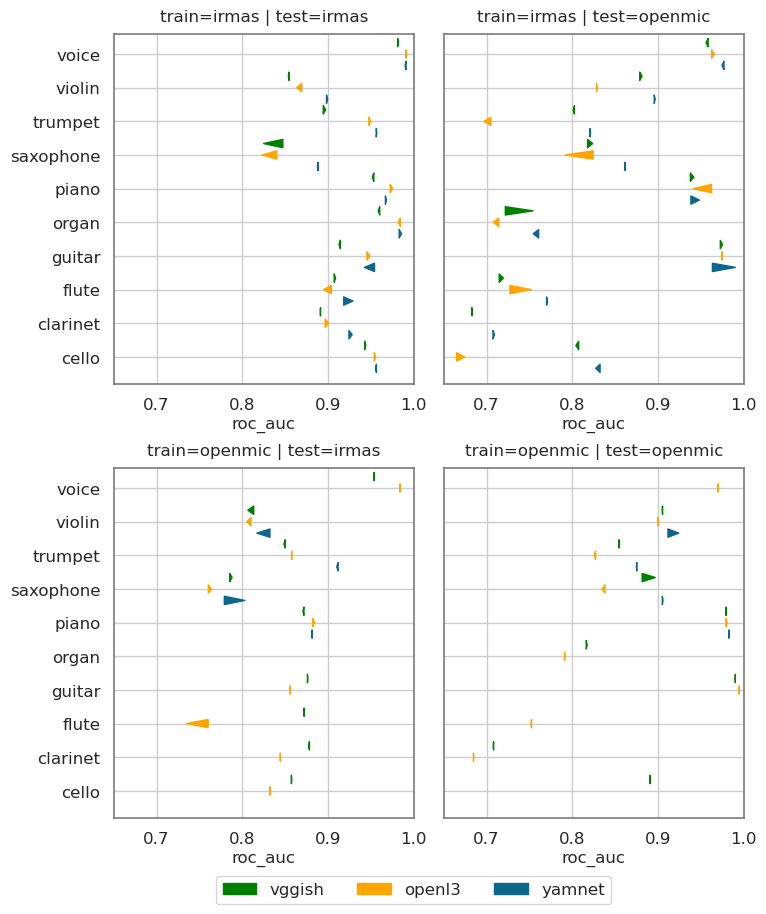

In [26]:
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

#         y = y - dist
#         x = list(df[df['embedding']==bias_lir_nonlir[2]][metric])
# #         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
#         for mark in range(len(y)):
#             ax.annotate('', (x[mark], y[mark]), 
#                     xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
#                         arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all_lda.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/irmas_only_lda.pdf', bbox_inches = "tight")

## original performance

In [27]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(instrument_map)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(instrument_map)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')

In [28]:
result_all = pd.read_csv('results/result_all_lda.csv')
result_all['debias_method'] = [list(result_all['embedding'])[k].replace(list(result_all['embedding'])[k].split('-')[0], '') \
                               for k in range(len(result_all['embedding']))]
result_all['embedding'] = [list(result_all['embedding'])[k].split('-')[0] \
                               for k in range(len(result_all['embedding']))]
result_all['debias_method'] = ['original' if k=='' else k for k in result_all['debias_method']] 

df = result_all[result_all['debias_method']=='original']
df = df.reset_index(drop=True)

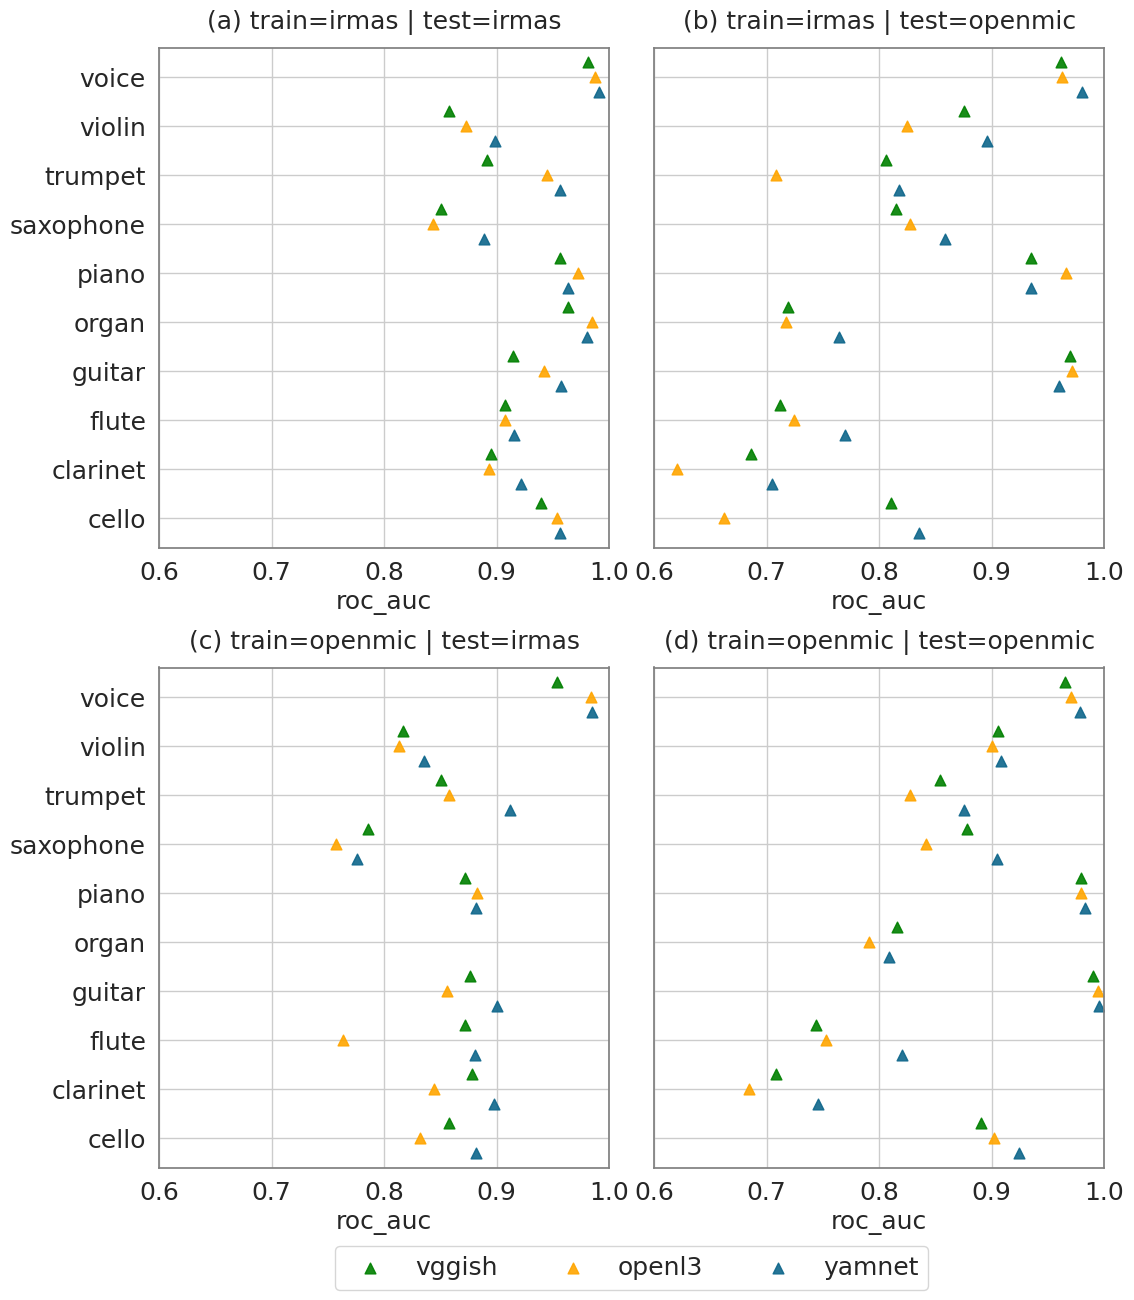

In [30]:
metric = 'roc_auc'
figure = plt.figure(figsize=(9,10))

size = 18
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   

train_set = 'openmic'; test_set = 'irmas'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])


train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.27)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'irmas'; test_set = 'openmic'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48]); ax.set_yticklabels([]);

plt.tight_layout(); 
plt.savefig('results/original_performance.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

## statistics

In [8]:
df1 = pd.read_csv('results/result_linear_all.csv')
df2 = pd.read_csv('results/result_nonlinear_all.csv')

df = df1.append(df2)

In [9]:
df

,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap,embedding
0,cello,irmas,irmas,0.272401,0.808511,0.407507,94.0,0.867347,0.915828,0.543231,vggish
1,clarinet,irmas,irmas,0.233996,0.834646,0.365517,127.0,0.779112,0.892076,0.561080,vggish
2,flute,irmas,irmas,0.332155,0.776860,0.465347,121.0,0.870348,0.910995,0.634701,vggish
3,guitar,irmas,irmas,0.552783,0.832370,0.664360,346.0,0.825330,0.914225,0.774766,vggish
4,organ,irmas,irmas,0.458333,0.885057,0.603922,174.0,0.878752,0.959235,0.706022,vggish
...,...,...,...,...,...,...,...,...,...,...,...
355,piano,openmic,irmas,0.194622,0.894118,0.319664,170.0,0.611645,0.892431,0.693666,yamnet-mklda
356,saxophone,openmic,irmas,0.222772,0.600000,0.324910,150.0,0.775510,0.768945,0.364086,yamnet-mklda
357,trumpet,openmic,irmas,0.318841,0.880000,0.468085,150.0,0.819928,0.913272,0.555592,yamnet-mklda
358,violin,openmic,irmas,0.215953,0.776224,0.337900,143.0,0.738896,0.821768,0.389431,yamnet-mklda


In [28]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-k', 'openl3-k', 'yamnet-k', 
              'vggish-klda', 'openl3-klda', 'yamnet-klda', 'vggish-mklda', 'openl3-mklda', 'yamnet-mklda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))
# case_mean_all = case_mean_all.reset_index(drop=True)

In [29]:
case_mean_all 

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.91475,NaN
0,vggish,openmic,openmic,0.873649,NaN
0,vggish,openmic,irmas,0.831517,NaN
0,vggish,irmas,openmic,0.83207,NaN
0,openl3,irmas,irmas,0.930487,NaN
0,openl3,openmic,openmic,0.863891,NaN
0,openl3,openmic,irmas,0.804848,NaN
0,openl3,irmas,openmic,0.795521,NaN
0,yamnet,irmas,irmas,0.945041,NaN
0,yamnet,openmic,openmic,0.897356,NaN


In [30]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [32]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [33]:
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [34]:
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [35]:
case_mean_all = case_mean_all.reset_index(drop=True)

In [36]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.91475,NaN
1,vggish,openmic,openmic,0.873649,NaN
2,vggish,openmic,irmas,0.831517,-0.083233
3,vggish,irmas,openmic,0.83207,-0.041579
4,openl3,irmas,irmas,0.930487,NaN
5,openl3,openmic,openmic,0.863891,NaN
6,openl3,openmic,irmas,0.804848,-0.125638
7,openl3,irmas,openmic,0.795521,-0.06837
8,yamnet,irmas,irmas,0.945041,NaN
9,yamnet,openmic,openmic,0.897356,NaN


In [37]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9147498177413251, 0.8736494613153635, 0.8315171818704133, 0.8320703204688492], change: [nan, nan, -0.08323263587091179, -0.04157914084651426]
openl3, mean: [0.9304868507705063, 0.8638908245675534, 0.8048484506213297, 0.7955206758385032], change: [nan, nan, -0.1256384001491766, -0.06837014872905023]
yamnet, mean: [0.9450405026462942, 0.8973559809874752, 0.8455992765788449, 0.8493510075642299], change: [nan, nan, -0.09944122606744932, -0.04800497342324528]
vggish-klda, mean: [0.917672612584909, 0.8814061167215195, 0.829417073464831, 0.8351312322953962], change: [nan, nan, -0.0021001084055823904, 0.003060911826546997]
openl3-klda, mean: [0.9348551596367191, 0.8725245734251809, 0.7843742791365491, 0.8013288798053744], change: [nan, nan, -0.02047417148478059, 0.005808203966871206]
yamnet-klda, mean: [0.945589144042056, 0.8982438745214013, 0.8486880041973155, 0.8494576965788321], change: [nan, nan, 0.003088727618470566, 0.00010668901460220148]
vggish-mklda, mean: [0.91747661

In [61]:
result_table = []
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])

In [62]:
df = pd.DataFrame(columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2'])
embeddings = ['vggish-k', 'openl3-k', 'yamnet-k'] + ['vggish-klda', 'openl3-klda', 'yamnet-klda'] + \
                    ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']
for k in range(len(result_table)):
    new_line = [embeddings[k]] + list(np.round(np.array(result_table[k]) * 100, 2))

    df = df.append(pd.DataFrame([new_line], 
        columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2']), 
        ignore_index=True)
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic,change1,change2
0,vggish-k,91.76,87.95,82.49,83.66,-0.66,0.45
1,openl3-k,93.87,87.21,79.06,80.76,-1.42,1.21
2,yamnet-k,94.56,89.81,84.65,85.87,0.09,0.93
3,vggish-klda,91.77,88.14,82.94,83.51,-0.21,0.31
4,openl3-klda,93.49,87.25,78.44,80.13,-2.05,0.58
5,yamnet-klda,94.56,89.82,84.87,84.95,0.31,0.01
6,vggish-mklda,91.75,87.78,82.29,83.04,-0.86,-0.16
7,openl3-mklda,93.69,87.08,78.95,80.62,-1.54,1.07
8,yamnet-mklda,94.36,89.79,84.72,85.24,0.16,0.3


In [63]:
df['change1'] = ['(' + str(item) + ')' for item in df['change1']]
df['change2'] = ['(' + str(item) + ')' for item in df['change2']]
df['openmic-irmas'] = [str(df['openmic-irmas'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df['irmas-openmic'] = [str(df['irmas-openmic'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df = df.drop(columns=['change1', 'change2'])
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish-k,91.76,87.95,82.49 (-0.66),83.66 (-0.66)
1,openl3-k,93.87,87.21,79.06 (-1.42),80.76 (-1.42)
2,yamnet-k,94.56,89.81,84.65 (0.09),85.87 (0.09)
3,vggish-klda,91.77,88.14,82.94 (-0.21),83.51 (-0.21)
4,openl3-klda,93.49,87.25,78.44 (-2.05),80.13 (-2.05)
5,yamnet-klda,94.56,89.82,84.87 (0.31),84.95 (0.31)
6,vggish-mklda,91.75,87.78,82.29 (-0.86),83.04 (-0.86)
7,openl3-mklda,93.69,87.08,78.95 (-1.54),80.62 (-1.54)
8,yamnet-mklda,94.36,89.79,84.72 (0.16),85.24 (0.16)


In [65]:
df.to_csv('results/result_table.csv', index=False)

(0.4, 1.0)

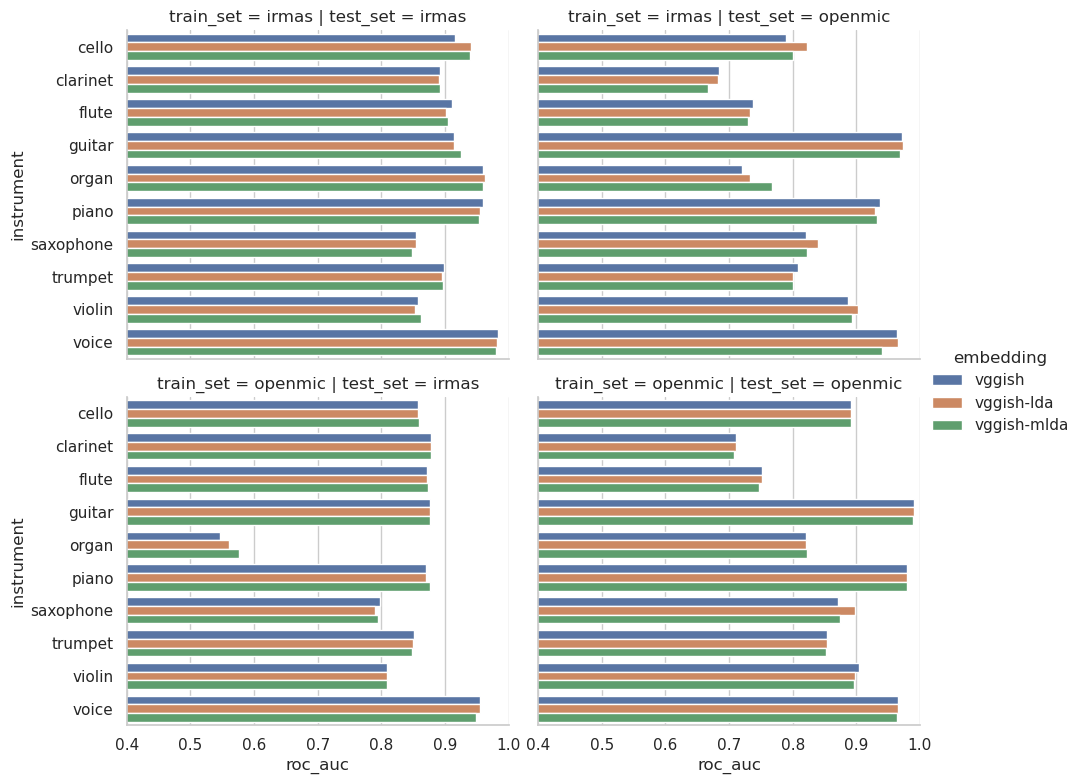

In [6]:
# save all result into a csv file
df = pd.read_csv('results/result_vggish-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

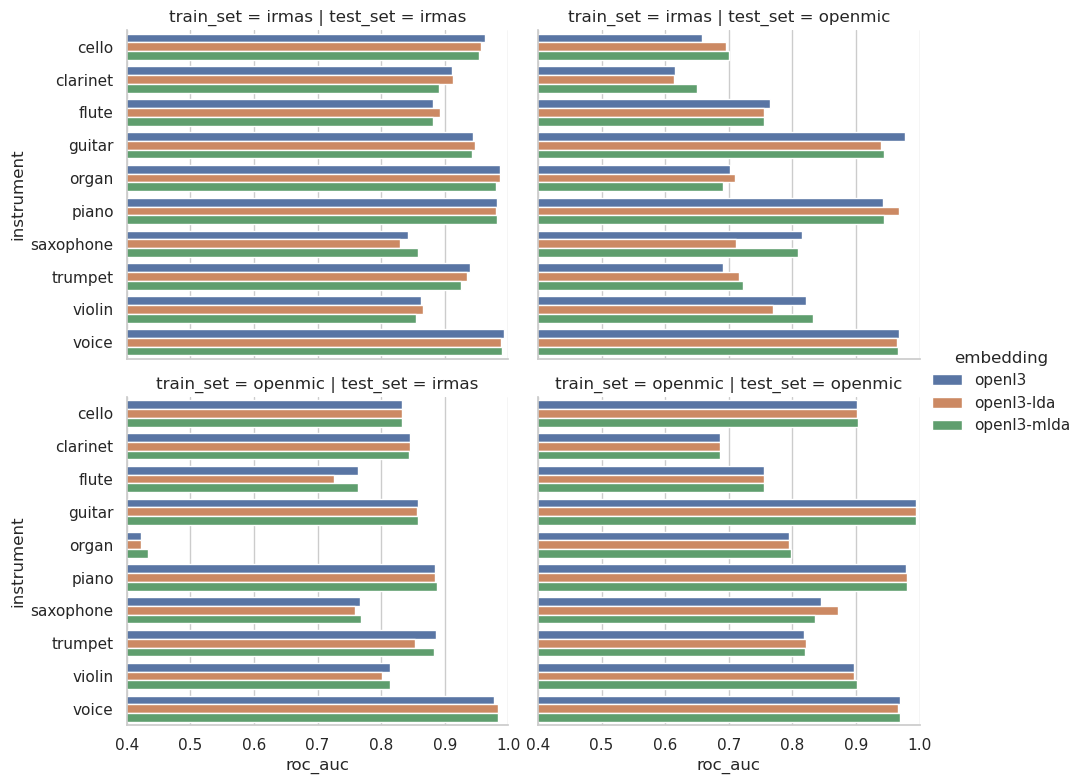

In [7]:
# save all result into a csv file
df = pd.read_csv('results/result_openl3-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')

(0.4, 1.0)

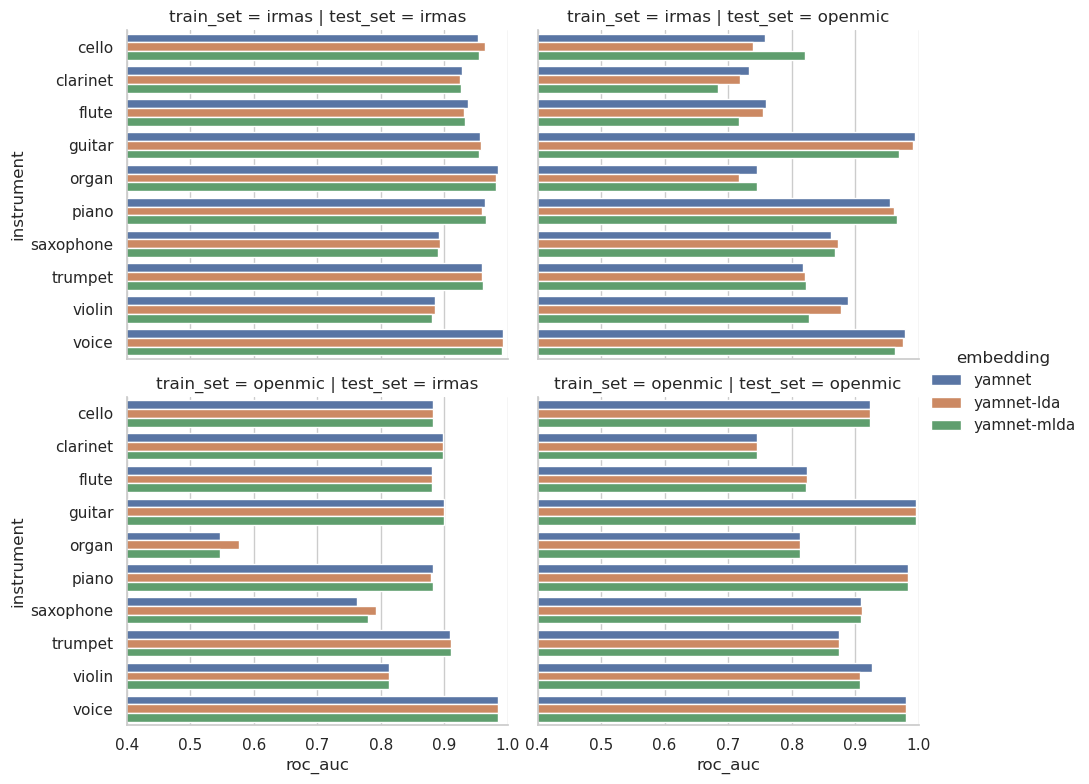

In [8]:
# save all result into a csv file
df = pd.read_csv('results/result_yamnet-mlda.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([.4,1])
# plt.savefig('results/' + embedding + '_ori_sameamount_aligninst.pdf', bbox_inches='tight')